# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [1]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
import keras.backend as K


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#
#tf.config.experimental.set_memory_growth(physical_devices[0], True) ## commeont out this

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?  
Ans:The RTX 3090 has 10,496 cuda cores.  
  
Question 2: How much memory does the graphics card have?  
Ans:The RTX 3090 has 24 GB of Vram.  
  
Question 3: What is stored in the GPU memory while training a DNN ?  
Ans:The model parameters, input data, gradient, and all the itermediate results are in Vram. Usually, it is in batches since it is normal that the data cannot fit in limited amount of Vram.

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [2]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')



# Remove the first 24 covariates (columns)
X = X[:,24:]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
unique, counts = np.unique(Y, return_counts=True)
for u, c in zip(unique, counts):
    print("The class ", u, "has", c, "counts");

The covariates have size (764137, 92).
The labels have size (764137,).
The class  0.0 has 121621 counts
The class  1.0 has 642516 counts


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.
  
Ans: We have create a short code to calculate the naive classifier accuracy below

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


In [3]:
# Naive classifier accuracy
naive_accur = max(counts[0]/(counts[0]+counts[1]),counts[1]/(counts[0]+counts[1]))
print("The naive classifier accuracy is", naive_accur)
      
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
# Print the number of NaNs (not a number) in the labels
print("There are ",np.sum(np.isnan(Y)),"NA in labels")

# Print the number of NaNs in the covariates
print("There are",np.sum(np.isnan(X)),"NA in covariates")

The naive classifier accuracy is 0.8408387501194158
There are  0 NA in labels
There are 0 NA in covariates


# Part 6: Preprocessing

Lets do some simple preprocessing

In [4]:
# Convert covariates to floats
X_float = X.astype(float)

# Convert labels to integers
Y_int = Y.astype(int)

# Remove mean of each covariate (column)
for column in range(len(X[0,])):
    X[:, column] = X[:, column]-np.mean(X[:, column])

# Divide each covariate (column) by its standard deviation
for column in range(len(X[0,])):
    X[:, column] = X[:, column]/np.std(X[:, column])

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
#for column in range(len(X[0,])):
for column in range(10):
    print(round(np.mean(X[:, column])))
    print(round(np.std(X[:, column])))# rounding is because they will not be exact 0 and 1 but very close

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [5]:
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=0.30)


print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
unique, counts = np.unique(Ytrain, return_counts=True)
for u, c in zip(unique, counts):
    print("The class ", u, "in training data has", c, "counts");

unique, counts = np.unique(Ytemp, return_counts=True)
for u, c in zip(unique, counts):
    print("The class ", u, "in the remaining 30% has", c, "counts");


Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).
The class  0.0 in training data has 85015 counts
The class  1.0 in training data has 449880 counts
The class  0.0 in the remaining 30% has 36606 counts
The class  1.0 in the remaining 30% has 192636 counts


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [6]:
from sklearn.model_selection import train_test_split

# Your code
Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5)

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))
#Yes, they have the shape that we expect

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).


In [7]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.losses import BinaryCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string

    if optimizer == "sgd":
        opt = SGD(learning_rate = learning_rate)
    elif optimizer == "adam":
        opt = Adam(learning_rate= learning_rate)        
    
    
    # Setup a sequential model
    model = Sequential()
    
    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Input(shape=input_shape))

    # Add remaining layers, do not require input shape
    for i in range(n_layers):
        if act_fun == 'sigmoid':
            model.add(Dense(n_nodes, activation=act_fun))
        if act_fun == 'relu':
            model.add(Dense(n_nodes, activation=act_fun))
        if use_bn:
            model.add(tf.keras.layers.BatchNormalization())
        if use_dropout:
            model.add(Dropout(0.5))
        if use_custom_dropout:
            model.add(myDropout(0.5))
    
    # Add final layer
    model.add(Dense(units=1, activation='sigmoid'))
    
    if optimizer == "sgd":
        opt = SGD(learning_rate = learning_rate)
    elif optimizer == "adam":
        opt = Adam(learning_rate= learning_rate)
    
    # Compile model
    model.compile(optimizer=opt, loss='BinaryCrossentropy', metrics=['accuracy'])
    
    return model

In [8]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [9]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = Xtrain.shape[1:]

# Build the model
model1 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False, use_custom_dropout=False)

# Train the model, provide training data and validation data
history1 = model1.fit(x=Xtrain,y=Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval, Yval))


Epoch 1/20
54/54 [==============================] - 1s 6ms/step - loss: 0.4045 - accuracy: 0.8413 - val_loss: 0.3607 - val_accuracy: 0.8410
Epoch 2/20
54/54 [==============================] - 0s 3ms/step - loss: 0.3294 - accuracy: 0.8411 - val_loss: 0.2969 - val_accuracy: 0.8410
Epoch 3/20
54/54 [==============================] - 0s 3ms/step - loss: 0.2705 - accuracy: 0.8448 - val_loss: 0.2468 - val_accuracy: 0.8551
Epoch 4/20
54/54 [==============================] - 0s 3ms/step - loss: 0.2318 - accuracy: 0.8618 - val_loss: 0.2191 - val_accuracy: 0.8734
Epoch 5/20
54/54 [==============================] - 0s 3ms/step - loss: 0.2117 - accuracy: 0.8839 - val_loss: 0.2050 - val_accuracy: 0.8935
Epoch 6/20
54/54 [==============================] - 0s 3ms/step - loss: 0.2010 - accuracy: 0.8978 - val_loss: 0.1971 - val_accuracy: 0.9021
Epoch 7/20
54/54 [==============================] - 0s 3ms/step - loss: 0.1948 - accuracy: 0.9016 - val_loss: 0.1921 - val_accuracy: 0.9030
Epoch 8/20
54/54 [==

In [10]:
# Evaluate the model on the test data
score = model1.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 2ms/step - loss: 0.1731 - accuracy: 0.9076
Test loss: 0.1731
Test accuracy: 0.9076


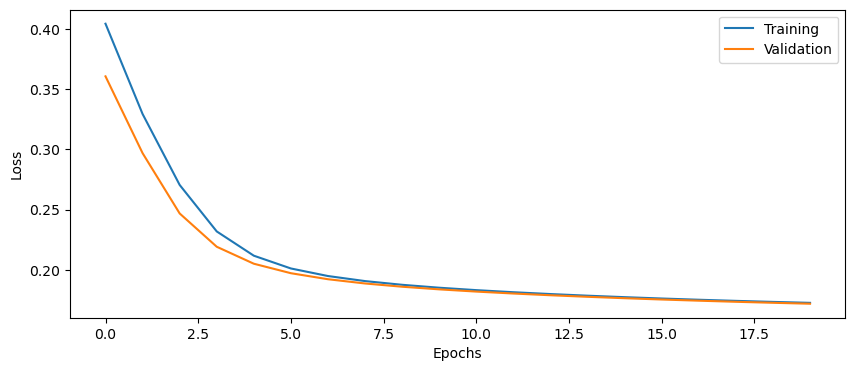

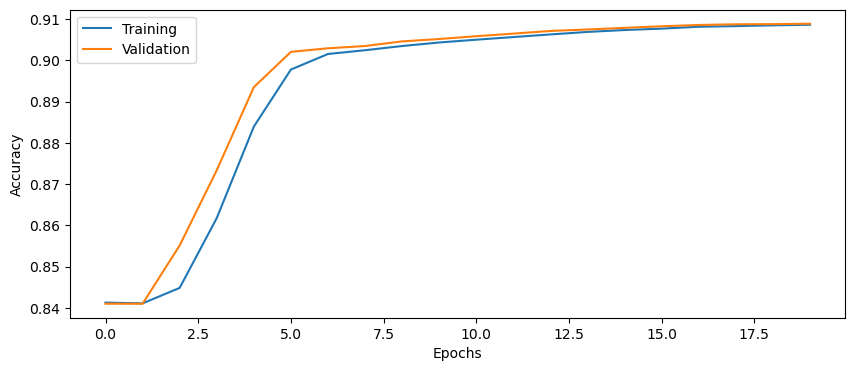

In [11]:
# Plot the history from the training run
plot_results(history1)

###### Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?  
Ans: Without specifying the activation function, the model will use linear transformation function as activation function.

Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?  
Ans: When using keras to crate dense layer, the default way to initialized weight is using glorot_uniform(Xavier uniform initializer) and zeros for bias. This is specify in the Dense class

# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [12]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight ="balanced",  classes =np.unique(Ytrain),  y =Ytrain)

# Print the class weights
print(class_weights)

# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights[0],
                 1: class_weights[1]}

print(class_weights)

[3.14588602 0.59448631]
{0: 3.1458860201140975, 1: 0.594486307459767}


### 2 layers, 20 nodes, class weights

In [13]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape =  Xtrain.shape[1:]

# Build and train model
model2 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False, use_custom_dropout=False)

history2 = model2.fit(x=Xtrain,y=Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval, Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 5ms/step - loss: 0.6023 - accuracy: 0.7354 - val_loss: 0.5187 - val_accuracy: 0.8808
Epoch 2/20
54/54 [==============================] - 0s 3ms/step - loss: 0.4207 - accuracy: 0.8805 - val_loss: 0.3576 - val_accuracy: 0.8809
Epoch 3/20
54/54 [==============================] - 0s 3ms/step - loss: 0.2928 - accuracy: 0.8806 - val_loss: 0.2934 - val_accuracy: 0.8815
Epoch 4/20
54/54 [==============================] - 0s 3ms/step - loss: 0.2445 - accuracy: 0.8816 - val_loss: 0.2747 - val_accuracy: 0.8829
Epoch 5/20
54/54 [==============================] - 0s 3ms/step - loss: 0.2264 - accuracy: 0.8829 - val_loss: 0.2655 - val_accuracy: 0.8843
Epoch 6/20
54/54 [==============================] - 0s 3ms/step - loss: 0.2175 - accuracy: 0.8848 - val_loss: 0.2609 - val_accuracy: 0.8866
Epoch 7/20
54/54 [==============================] - 0s 3ms/step - loss: 0.2120 - accuracy: 0.8869 - val_loss: 0.2567 - val_accuracy: 0.8887
Epoch 8/20
54/54 [==

In [14]:
# Evaluate model on test data
score = model2.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 2ms/step - loss: 0.2340 - accuracy: 0.9004
Test loss: 0.2340
Test accuracy: 0.9004


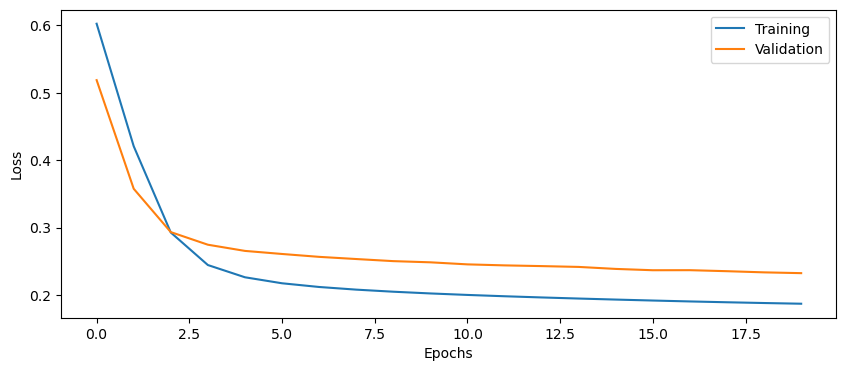

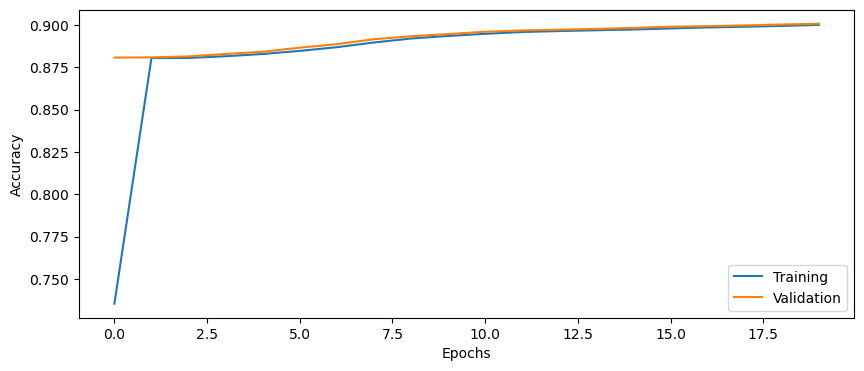

In [15]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

Ans: This is because in most case the data cannot being fit into the momory, so the data need to be slice into smaller batches

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  
Ans: If the batch size is 100, in each epoch the weights get update 534895/100 =5349times
     If the batch size is 1000, in each epoch the weights get update 534895/1000 =535times
     If the batch size is 10000, in each epoch the weights get update 534895/10000 =54times

Question 11: What limits how large the batch size can be?  
Ans:The biggest limitation of batch size is still the memory(vram), if the batch size is too big it will still result the data cannot be fit into memory.

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?  
Ans: In short, when the batch size increase, the learning rate can also be increase, and vice versa.

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()  
Ans: As the belowsummary shown, there are 12351 parameters for 4 layer and 50 nodes model. On the other hand, there are 2301 parameters for 2 layers and 20 nodes model.

In [16]:
model4_50 = build_DNN(input_shape, n_layers=4, n_nodes=50, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False, use_custom_dropout=False)
model4_50.summary()
print("-----Next Model-----")
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                4650      
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12,351
Trainable params: 12,351
Non-trainable params: 0
_________________________________________________________________
-----Next Model-----
Model: "sequential_1"
_______

### 4 layers, 20 nodes, class weights

In [17]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape =  Xtrain.shape[1:]

# Build and train model
model3 = build_DNN(input_shape, n_layers=4, n_nodes=20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False, use_custom_dropout=False)
model3.summary()
history3 = model3.fit(x=Xtrain,y=Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval, Yval),class_weight=class_weights)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 20)                1860      
                                                                 
 dense_12 (Dense)            (None, 20)                420       
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dense_14 (Dense)            (None, 20)                420       
                                                                 
 dense_15 (Dense)            (None, 1)                 21        
                                                                 
Total params: 3,141
Trainable params: 3,141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
54/54 [==============================] - 

In [18]:
# Evaluate model on test data
score = model3.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 2ms/step - loss: 0.4035 - accuracy: 0.8791
Test loss: 0.4035
Test accuracy: 0.8791


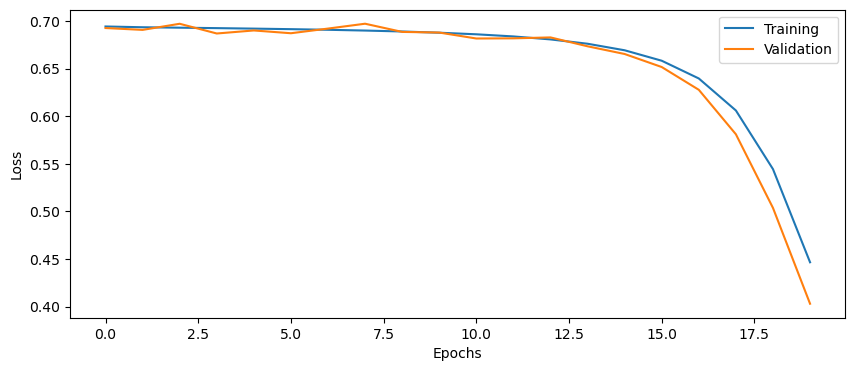

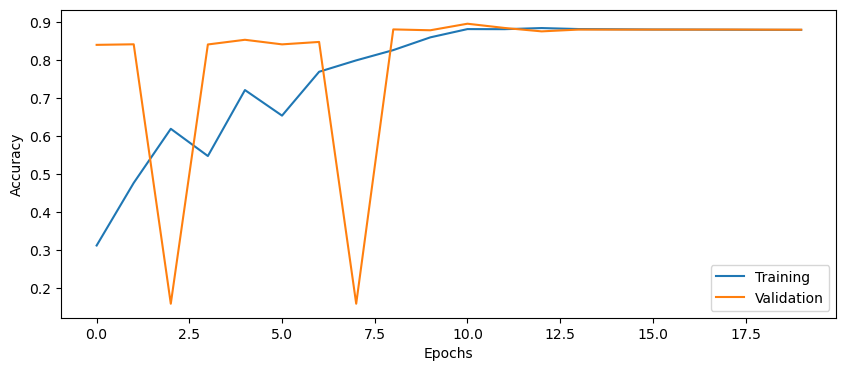

In [19]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [20]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape =  Xtrain.shape[1:]

# Build and train model
model4 = build_DNN(input_shape, n_layers=2, n_nodes=50, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False, use_custom_dropout=False)

history4 = model4.fit(x=Xtrain,y=Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval, Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 8ms/step - loss: 0.5755 - accuracy: 0.8160 - val_loss: 0.4649 - val_accuracy: 0.8887
Epoch 2/20
54/54 [==============================] - 0s 6ms/step - loss: 0.3684 - accuracy: 0.8843 - val_loss: 0.3204 - val_accuracy: 0.8842
Epoch 3/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2639 - accuracy: 0.8842 - val_loss: 0.2811 - val_accuracy: 0.8858
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2320 - accuracy: 0.8872 - val_loss: 0.2677 - val_accuracy: 0.8894
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2194 - accuracy: 0.8900 - val_loss: 0.2609 - val_accuracy: 0.8919
Epoch 6/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2125 - accuracy: 0.8917 - val_loss: 0.2574 - val_accuracy: 0.8930
Epoch 7/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2076 - accuracy: 0.8930 - val_loss: 0.2523 - val_accuracy: 0.8943
Epoch 8/20
54/54 [==

In [21]:
# Evaluate model on test data
score = model4.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 3ms/step - loss: 0.2312 - accuracy: 0.9032
Test loss: 0.2312
Test accuracy: 0.9032


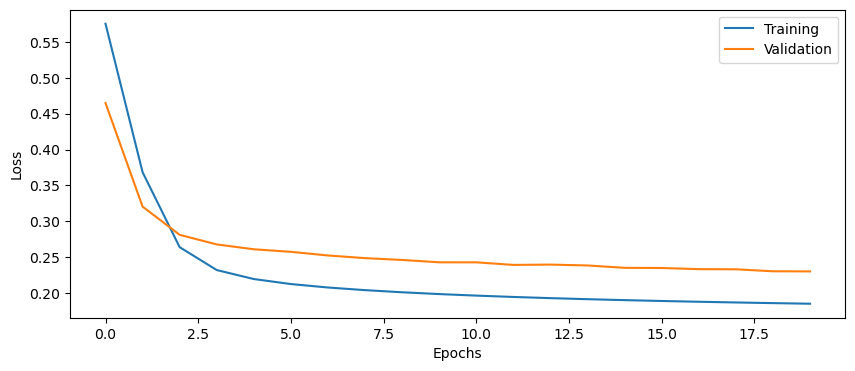

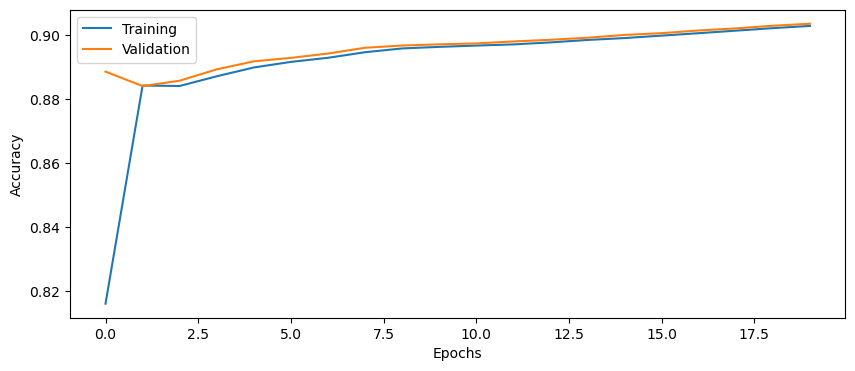

In [22]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [23]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape =  Xtrain.shape[1:]

# Build and train model
model5 = build_DNN(input_shape, n_layers=4, n_nodes=50, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False, use_custom_dropout=False)

history5 = model5.fit(x=Xtrain,y=Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval, Yval),class_weight=class_weights) 

Epoch 1/20
54/54 [==============================] - 1s 11ms/step - loss: 0.6932 - accuracy: 0.6560 - val_loss: 0.6998 - val_accuracy: 0.1590
Epoch 2/20
54/54 [==============================] - 0s 9ms/step - loss: 0.6903 - accuracy: 0.5769 - val_loss: 0.6811 - val_accuracy: 0.8410
Epoch 3/20
54/54 [==============================] - 0s 9ms/step - loss: 0.6887 - accuracy: 0.7464 - val_loss: 0.6975 - val_accuracy: 0.1590
Epoch 4/20
54/54 [==============================] - 1s 9ms/step - loss: 0.6865 - accuracy: 0.7525 - val_loss: 0.6729 - val_accuracy: 0.8412
Epoch 5/20
54/54 [==============================] - 1s 9ms/step - loss: 0.6836 - accuracy: 0.8760 - val_loss: 0.6771 - val_accuracy: 0.8919
Epoch 6/20
54/54 [==============================] - 1s 9ms/step - loss: 0.6792 - accuracy: 0.8806 - val_loss: 0.6743 - val_accuracy: 0.8797
Epoch 7/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6725 - accuracy: 0.8802 - val_loss: 0.6528 - val_accuracy: 0.8750
Epoch 8/20
54/54 [

In [24]:
# Evaluate model on test data
score = model5.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 4ms/step - loss: 0.2512 - accuracy: 0.8923
Test loss: 0.2512
Test accuracy: 0.8923


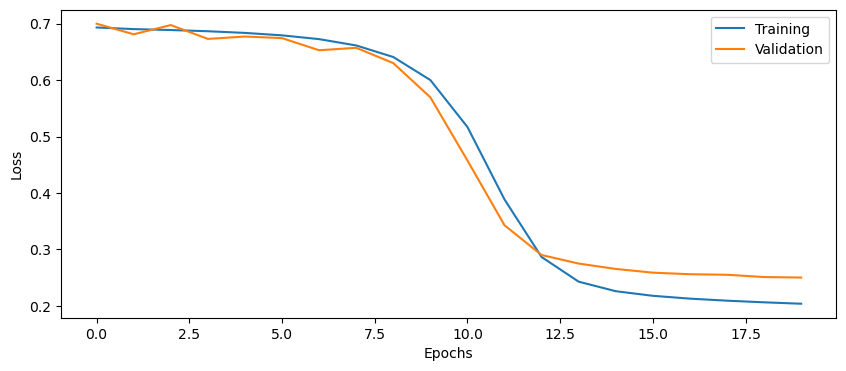

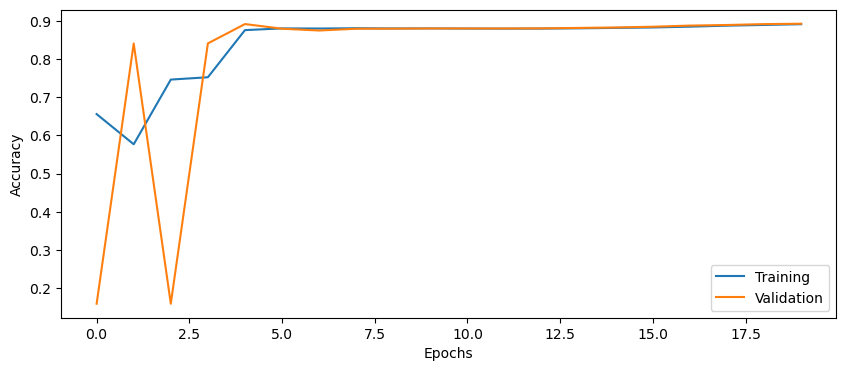

In [25]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?  
Ans: Doing batch normalization is to keep the input data normalized, which can be very helpful to prevent the gradient calculation being unstable or even result in exploded or vanish gradient as it reduce the magnitude of gradients.

### 2 layers, 20 nodes, class weights, batch normalization

In [26]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape =  Xtrain.shape[1:]

# Build and train model
model6 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=True, use_dropout=False, use_custom_dropout=False)

history6 = model6.fit(x=Xtrain,y=Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval, Yval),class_weight=class_weights) 

Epoch 1/20
54/54 [==============================] - 1s 7ms/step - loss: 0.2906 - accuracy: 0.8796 - val_loss: 0.4134 - val_accuracy: 0.8410
Epoch 2/20
54/54 [==============================] - 0s 5ms/step - loss: 0.2113 - accuracy: 0.9023 - val_loss: 0.3339 - val_accuracy: 0.8410
Epoch 3/20
54/54 [==============================] - 0s 5ms/step - loss: 0.1917 - accuracy: 0.9097 - val_loss: 0.2874 - val_accuracy: 0.8410
Epoch 4/20
54/54 [==============================] - 0s 5ms/step - loss: 0.1832 - accuracy: 0.9118 - val_loss: 0.2409 - val_accuracy: 0.8423
Epoch 5/20
54/54 [==============================] - 0s 4ms/step - loss: 0.1781 - accuracy: 0.9129 - val_loss: 0.1989 - val_accuracy: 0.8733
Epoch 6/20
54/54 [==============================] - 0s 4ms/step - loss: 0.1747 - accuracy: 0.9137 - val_loss: 0.1764 - val_accuracy: 0.9078
Epoch 7/20
54/54 [==============================] - 0s 4ms/step - loss: 0.1722 - accuracy: 0.9144 - val_loss: 0.1732 - val_accuracy: 0.9156
Epoch 8/20
54/54 [==

In [27]:
# Evaluate model on test data
score = model6.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 2ms/step - loss: 0.2009 - accuracy: 0.9173
Test loss: 0.2009
Test accuracy: 0.9173


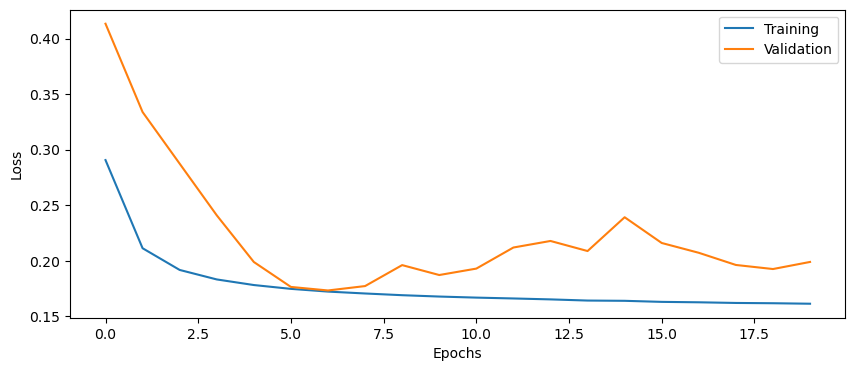

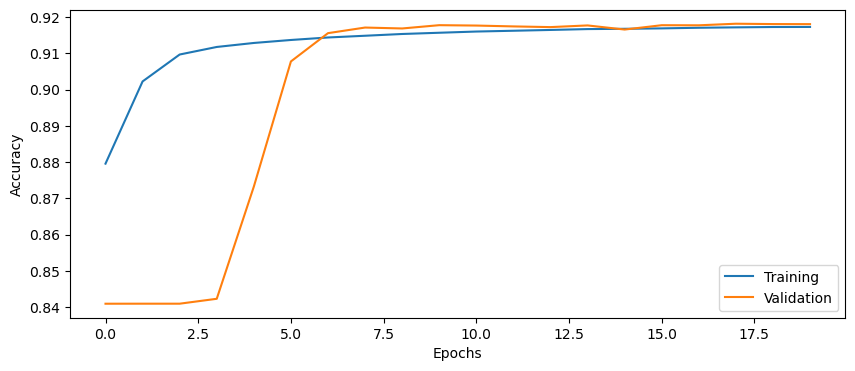

In [28]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [29]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train model
model7 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='relu', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False, use_custom_dropout=False)

history7 = model7.fit(x=Xtrain,y=Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval, Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 5ms/step - loss: 0.3182 - accuracy: 0.8829 - val_loss: 0.2712 - val_accuracy: 0.8922
Epoch 2/20
54/54 [==============================] - 0s 3ms/step - loss: 0.2016 - accuracy: 0.8958 - val_loss: 0.2438 - val_accuracy: 0.9005
Epoch 3/20
54/54 [==============================] - 0s 3ms/step - loss: 0.1886 - accuracy: 0.9032 - val_loss: 0.2334 - val_accuracy: 0.9067
Epoch 4/20
54/54 [==============================] - 0s 3ms/step - loss: 0.1820 - accuracy: 0.9072 - val_loss: 0.2290 - val_accuracy: 0.9091
Epoch 5/20
54/54 [==============================] - 0s 3ms/step - loss: 0.1781 - accuracy: 0.9090 - val_loss: 0.2271 - val_accuracy: 0.9104
Epoch 6/20
54/54 [==============================] - 0s 3ms/step - loss: 0.1754 - accuracy: 0.9104 - val_loss: 0.2213 - val_accuracy: 0.9119
Epoch 7/20
54/54 [==============================] - 0s 3ms/step - loss: 0.1734 - accuracy: 0.9114 - val_loss: 0.2219 - val_accuracy: 0.9125
Epoch 8/20
54/54 [==

In [30]:
# Evaluate model on test data
score = model7.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 2ms/step - loss: 0.2008 - accuracy: 0.9158
Test loss: 0.2008
Test accuracy: 0.9158


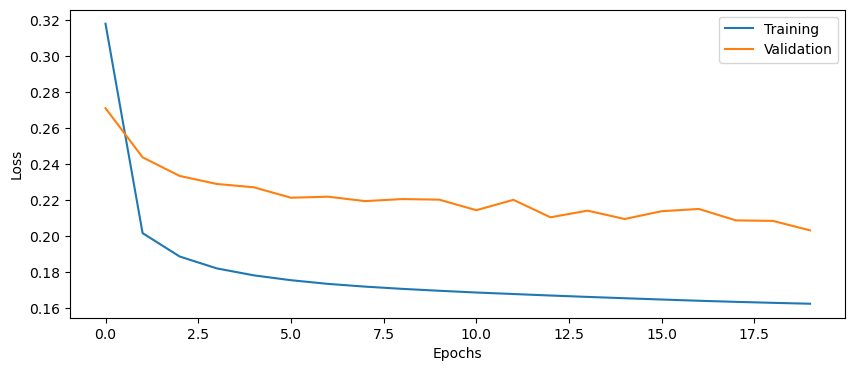

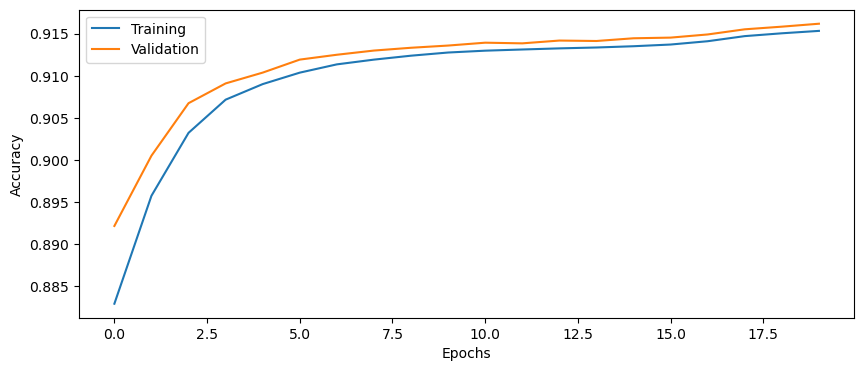

In [31]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [32]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train model
model8 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='adam', learning_rate=0.1, use_bn=False, use_dropout=False, use_custom_dropout=False)

history8 = model8.fit(x=Xtrain,y=Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval, Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 5ms/step - loss: 0.2246 - accuracy: 0.8845 - val_loss: 0.2208 - val_accuracy: 0.9128
Epoch 2/20
54/54 [==============================] - 0s 3ms/step - loss: 0.1709 - accuracy: 0.9137 - val_loss: 0.2135 - val_accuracy: 0.9157
Epoch 3/20
54/54 [==============================] - 0s 3ms/step - loss: 0.1657 - accuracy: 0.9162 - val_loss: 0.2084 - val_accuracy: 0.9171
Epoch 4/20
54/54 [==============================] - 0s 3ms/step - loss: 0.1621 - accuracy: 0.9175 - val_loss: 0.2047 - val_accuracy: 0.9188
Epoch 5/20
54/54 [==============================] - 0s 3ms/step - loss: 0.1578 - accuracy: 0.9187 - val_loss: 0.1958 - val_accuracy: 0.9191
Epoch 6/20
54/54 [==============================] - 0s 3ms/step - loss: 0.1549 - accuracy: 0.9199 - val_loss: 0.2038 - val_accuracy: 0.9198
Epoch 7/20
54/54 [==============================] - 0s 3ms/step - loss: 0.1512 - accuracy: 0.9201 - val_loss: 0.1833 - val_accuracy: 0.9193
Epoch 8/20
54/54 [==

In [33]:
# Evaluate model on test data
score = model8.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 2ms/step - loss: 0.1566 - accuracy: 0.9329
Test loss: 0.1566
Test accuracy: 0.9329


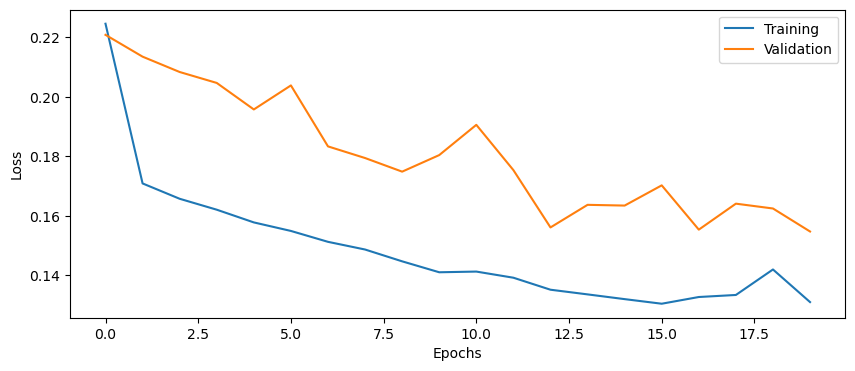

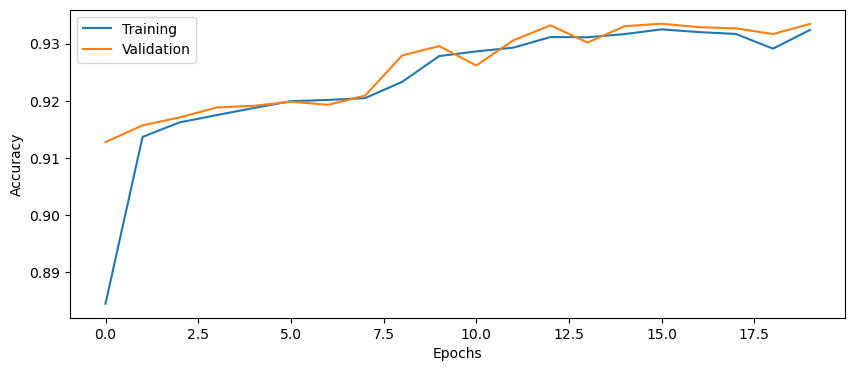

In [34]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?  
Ans: Compare to not using dropout, the validation accuracy stays roughly the same when adding dropout.

Question 16: How does the test accuracy change when adding dropout?  
Ans: Compare to model2, which the only difference is adding dropout, the accuracy stays similar but we expericend 1% lower accuracy when adding dropout

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [35]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train model
model9 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=True, use_custom_dropout=False)

history9 = model9.fit(x=Xtrain,y=Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval, Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 7ms/step - loss: 0.7035 - accuracy: 0.5982 - val_loss: 0.6015 - val_accuracy: 0.8872
Epoch 2/20
54/54 [==============================] - 0s 5ms/step - loss: 0.6103 - accuracy: 0.6697 - val_loss: 0.5027 - val_accuracy: 0.8866
Epoch 3/20
54/54 [==============================] - 0s 5ms/step - loss: 0.5334 - accuracy: 0.7493 - val_loss: 0.4206 - val_accuracy: 0.8808
Epoch 4/20
54/54 [==============================] - 0s 5ms/step - loss: 0.4645 - accuracy: 0.7929 - val_loss: 0.3503 - val_accuracy: 0.8804
Epoch 5/20
54/54 [==============================] - 0s 5ms/step - loss: 0.4119 - accuracy: 0.8200 - val_loss: 0.3102 - val_accuracy: 0.8801
Epoch 6/20
54/54 [==============================] - 0s 5ms/step - loss: 0.3746 - accuracy: 0.8365 - val_loss: 0.2901 - val_accuracy: 0.8800
Epoch 7/20
54/54 [==============================] - 0s 5ms/step - loss: 0.3479 - accuracy: 0.8465 - val_loss: 0.2810 - val_accuracy: 0.8800
Epoch 8/20
54/54 [==

In [36]:
# Evaluate model on test data
score = model9.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 2ms/step - loss: 0.2687 - accuracy: 0.8793
Test loss: 0.2687
Test accuracy: 0.8793


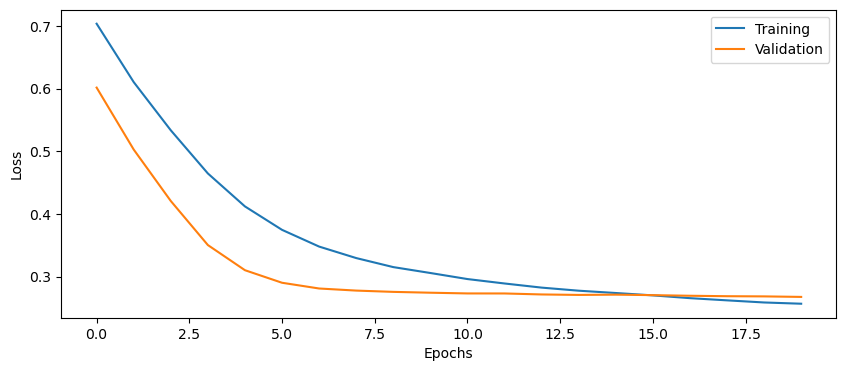

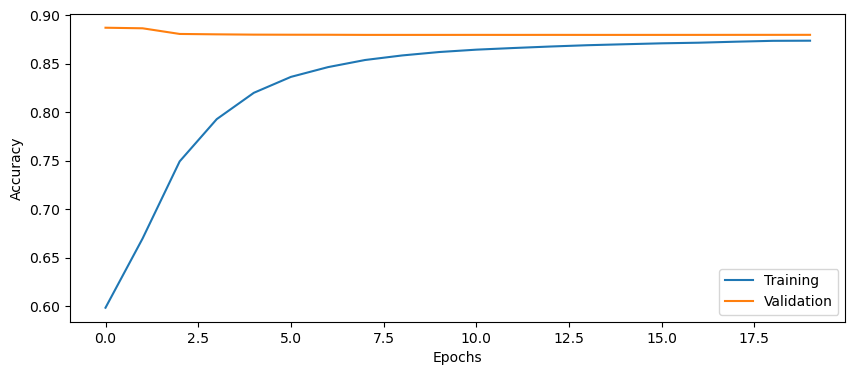

In [37]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?  
Ans: We achive about 0.935 test accuracy by using batch_size = 1000, epochs = 30, 4 Dense layers, 60 nodes on each layer, sigmoid activation function, adam optimizer, learing rate =0.01 with batch normalization and other false.

In [38]:
# Find your best configuration for the DNN

batch_size = 1000
epochs = 30
input_shape = Xtrain.shape[1:]

# Build and train DNN
model10 = build_DNN(input_shape, n_layers=4, n_nodes=60, act_fun='sigmoid', optimizer='adam', learning_rate=0.01, use_bn=True, use_dropout=False, use_custom_dropout=False)

history10 = model10.fit(x=Xtrain,y=Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval, Yval),class_weight=class_weights)


Epoch 1/30
535/535 [==============================] - 3s 3ms/step - loss: 0.1739 - accuracy: 0.9135 - val_loss: 0.2550 - val_accuracy: 0.9159
Epoch 2/30
535/535 [==============================] - 2s 3ms/step - loss: 0.1556 - accuracy: 0.9201 - val_loss: 0.2359 - val_accuracy: 0.9170
Epoch 3/30
535/535 [==============================] - 2s 3ms/step - loss: 0.1424 - accuracy: 0.9280 - val_loss: 0.2093 - val_accuracy: 0.9297
Epoch 4/30
535/535 [==============================] - 2s 3ms/step - loss: 0.1422 - accuracy: 0.9276 - val_loss: 0.1749 - val_accuracy: 0.9328
Epoch 5/30
535/535 [==============================] - 2s 4ms/step - loss: 0.1344 - accuracy: 0.9314 - val_loss: 0.1430 - val_accuracy: 0.9317
Epoch 6/30
535/535 [==============================] - 2s 3ms/step - loss: 0.1326 - accuracy: 0.9325 - val_loss: 0.1690 - val_accuracy: 0.9331
Epoch 7/30
535/535 [==============================] - 2s 3ms/step - loss: 0.1308 - accuracy: 0.9332 - val_loss: 0.1934 - val_accuracy: 0.9355
Epoch 

In [39]:
# Evaluate DNN on test data
score = model10.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

115/115 [==============================] - 0s 1ms/step - loss: 0.1428 - accuracy: 0.9359
Test loss: 0.1428
Test accuracy: 0.9359


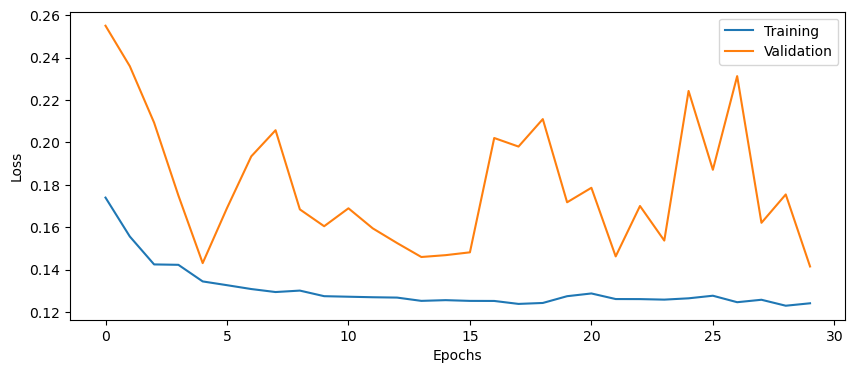

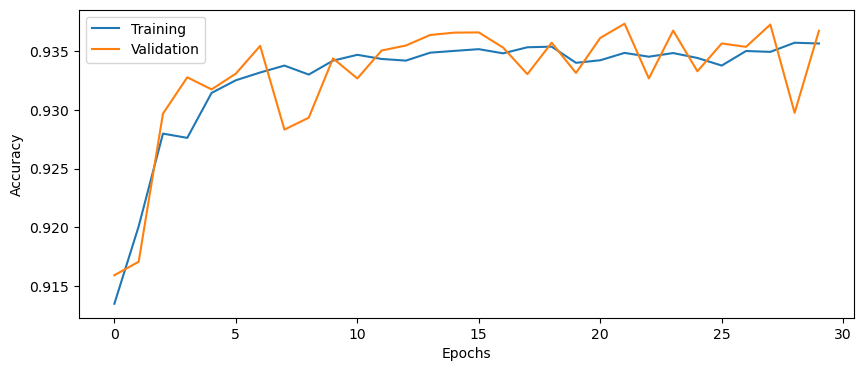

In [40]:
plot_results(history10)

# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 18: What is the mean and the standard deviation of the test accuracy?  
Ans: We have write the code to show the mean and sd for test accuracy below.

In [41]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [52]:
# Your best training parameters

batch_size = 1000
epochs = 30
input_shape = Xtrain.shape[1:]

# Build and train model
model11 = build_DNN(input_shape, n_layers=4, n_nodes=60, act_fun='sigmoid', optimizer='adam', learning_rate=0.01, use_bn=True, use_dropout=False, use_custom_dropout=True)

history11 = model11.fit(x=Xtrain,y=Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval, Yval),class_weight=class_weights)

Epoch 1/30
688/688 [==============================] - 6s 7ms/step - loss: 0.1935 - accuracy: 0.9076 - val_loss: 0.2300 - val_accuracy: 0.9150
Epoch 2/30
688/688 [==============================] - 4s 7ms/step - loss: 0.1757 - accuracy: 0.9143 - val_loss: 0.2048 - val_accuracy: 0.9155
Epoch 3/30
688/688 [==============================] - 4s 6ms/step - loss: 0.1736 - accuracy: 0.9148 - val_loss: 0.2093 - val_accuracy: 0.9156
Epoch 4/30
688/688 [==============================] - 4s 6ms/step - loss: 0.1724 - accuracy: 0.9150 - val_loss: 0.2254 - val_accuracy: 0.9147
Epoch 5/30
688/688 [==============================] - 4s 6ms/step - loss: 0.1713 - accuracy: 0.9154 - val_loss: 0.2107 - val_accuracy: 0.9157
Epoch 6/30
688/688 [==============================] - 4s 6ms/step - loss: 0.1716 - accuracy: 0.9151 - val_loss: 0.2282 - val_accuracy: 0.9144
Epoch 7/30
688/688 [==============================] - 4s 6ms/step - loss: 0.1709 - accuracy: 0.9153 - val_loss: 0.2239 - val_accuracy: 0.9147
Epoch 

In [53]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)
                       
print('Test accuracy: %.4f' % score[1])

77/77 [==============================] - 0s 3ms/step - loss: 0.2195 - accuracy: 0.9157
Test accuracy: 0.9157


In [54]:
# Run the testing 100 times, and save the accuracies in an array

score_array = []
for i in range(1,100):
    score_array.append(model11.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)[1])
    
# Calculate and print mean and std of accuracies

77/77 [==============================] - 0s 3ms/step - loss: 0.2185 - accuracy: 0.9162


In [51]:
print(np.mean(score_array))
print(np.std(score_array))

0.9199093140736975
0.00013394494327571615


# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?  
Ans: We have include the code to calculate and print the mean and sd below.

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.  
Ans: The main advantage of dropout is time saving compare to CV and still manage to obtain an estimate of the model uncertaint.

In [55]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=1234)
score_array = []

# Loop over cross validation folds
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={test_index}")
    Xtrain = X[train_index]
    Ytrain =Y[train_index]
    Xtest =X[test_index]
    Ytest =Y[test_index]


    # Calculate class weights for current split
    class_weights = class_weight.compute_class_weight(class_weight ="balanced",  classes = np.unique(Ytrain),  y =Ytrain)
    class_weights = {0: class_weights[0],
                 1: class_weights[1]}
    
    # Rebuild the DNN model, to not continue training on the previously trained model
    # Fit the model with training set and class weights for this fold
    batch_size = 1000
    epochs = 30
    input_shape = Xtrain.shape[1:]
    modelfold = build_DNN(input_shape, n_layers=4, n_nodes=60, act_fun='sigmoid', optimizer='adam', learning_rate=0.01, use_bn=True, use_dropout=False, use_custom_dropout=False)
    historyfold = modelfold.fit(x=Xtrain,y=Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval, Yval),class_weight=class_weights)
    # Evaluate the model using the test set for this fold
    score = model11.evaluate(x=Xtest,y=Ytest,batch_size=batch_size)[1]
    print(f"Fold accuracy",score)
    # Save the test accuracy in an array
    score_array.append(score)

Fold 0:
Epoch 1/30
688/688 [==============================] - 4s 4ms/step - loss: 0.1711 - accuracy: 0.9146 - val_loss: 0.1887 - val_accuracy: 0.9188
Epoch 2/30
688/688 [==============================] - 3s 4ms/step - loss: 0.1519 - accuracy: 0.9223 - val_loss: 0.1782 - val_accuracy: 0.9204
Epoch 3/30
688/688 [==============================] - 3s 4ms/step - loss: 0.1416 - accuracy: 0.9283 - val_loss: 0.1700 - val_accuracy: 0.9316
Epoch 4/30
688/688 [==============================] - 3s 4ms/step - loss: 0.1338 - accuracy: 0.9319 - val_loss: 0.1699 - val_accuracy: 0.9330
Epoch 5/30
688/688 [==============================] - 3s 4ms/step - loss: 0.1344 - accuracy: 0.9309 - val_loss: 0.1666 - val_accuracy: 0.9351
Epoch 6/30
688/688 [==============================] - 3s 4ms/step - loss: 0.1289 - accuracy: 0.9337 - val_loss: 0.1461 - val_accuracy: 0.9356
Epoch 7/30
688/688 [==============================] - 3s 4ms/step - loss: 0.1253 - accuracy: 0.9346 - val_loss: 0.1577 - val_accuracy: 0.929

In [56]:
print(np.mean(score_array))
print(np.std(score_array))

0.9163605511188507
0.0010262280507468793


# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN used in this lab in order to use it for regression instead?

Ans: To use DNN for regression we have to remove the sigmoid output layer and replace it with the linear activation function. Also, we have to change the Loss function to suit the regression model.

## Report

Send in this jupyter notebook, with answers to all questions.